In [10]:
import random
import time 
import numpy as np
import matplotlib.pyplot as plt
import openjij as oj
#PyQUBO
from pyqubo import Array, Constraint, Placeholder, solve_qubo

In [11]:
#グラフを定義。ここでは0~7と名前をつけた8個の頂点 を持つグラフを定義。
#(0,1)の場合、頂点0と頂点1がつながっていることを示す。
graph = [(0,1), (0,2), (1,3), (5,6), (2,3), (2,5), (3,4), (5,7)]

In [12]:
def PyQUBO(graph):
    # BINARY変数
    x = Array.create('x', shape=8, vartype='BINARY')
    
    # プレースホルダー
    param_cover = Placeholder("cover")
    # QUBO形式で定式化
    H_cover = Constraint(sum((1-x[u])*(1-x[v]) for(u,v) in graph), "cover")
    H_A = sum(x) #最小化項
    H_B = H_cover#*param_cover  #ペナルティ項
    
    Q = H_A+H_B #コスト関数
    
    # モデルをコンパイル
    model = Q.compile()
    # プレースホルダーと合わせてQUBOを作成
    feed_dict = {'cover': param_cover}
    qubo, offset = model.to_qubo(feed_dict=feed_dict)
    
    #PyQUBOによるSA
    raw_solution = solve_qubo(qubo)
    # 得られた結果をデコードする
    decoded_solution, broken, energy = \
        model.decode_solution(raw_solution, vartype="BINARY", feed_dict=feed_dict)
    return qubo,decoded_solution

In [13]:
# 最適解
correct_state = [1, 0, 0, 1, 0, 1, 0, 0]

#[(-1)**i for i in range(N)]
print(correct_state)

[1, 0, 0, 1, 0, 1, 0, 0]


In [14]:
Q,resultPyQUBO = PyQUBO(graph)

# TTS を計算するのに必要なp^R
pR = 0.99

# Samplerの引数のstep_num というパラメータに渡すリスト(step_num_list) 
# step_num はアニーリング中のパラメータ(温度, 横磁場)を下げていくときの分割数だと思って良い
# なので増やせば増やすほどゆっくりアニーリングすることになってアニーリング時間が伸びる。
step_num_list = [10, 20, 30, 40]

# 各計算時間に対するTTSを格納しておくリスト
TTS_list = []
tau_list = []  # 計算時間を格納しておくリスト

iteration = 2000  # 確率を計算するために1回のアニーリングを行う回数

for step_num in step_num_list:
    start = time.time()
    # beta_max と　beta_min はSAのアルゴリズムで使うパラメータ. 今は特に気にしなくて良い.
    sampler = oj.SASampler(beta_max=10.0, beta_min=0.01, step_num=step_num, iteration=iteration)  # 確率p_sを計算するために500回計算する
    tau = (time.time() - start)/iteration  # 1回のアニーリング時間の計算時間の計測
    
    response = sampler.sample_qubo(Q)
    
    # 返ってきた解であっている状態の数を数えて最適解を得た確率を計算する。
    ps = sum([1 if state == correct_state else 0 for state in response.states])/iteration
    
    # ps=0だとTTSが無限大になってしまうのでそこは回避
    if ps == 0:
        continue
    
    # TTSを計算する
    TTS_list.append(np.log(1-pR)/np.log(1-ps)*tau)
    tau_list.append(tau)
    

In [15]:
print(response.states)
print(tau_list)
print(TTS_list)

[[0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 0, 1

Text(0, 0.5, 'TTS')

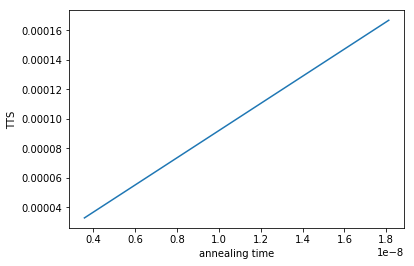

In [16]:
plt.plot(tau_list, TTS_list)
plt.xlabel('annealing time')
plt.ylabel('TTS')

In [22]:
result = oj.benchmark(true_ground_states=[correct_state], ground_energy=0, 
                      solver= lambda time_param, iteration: oj.SASampler(step_num=time_param, iteration=iteration).sample_qubo(Q),
                      time_param_list=step_num_list)

time parameter:  10
time parameter:  20
time parameter:  30
time parameter:  40


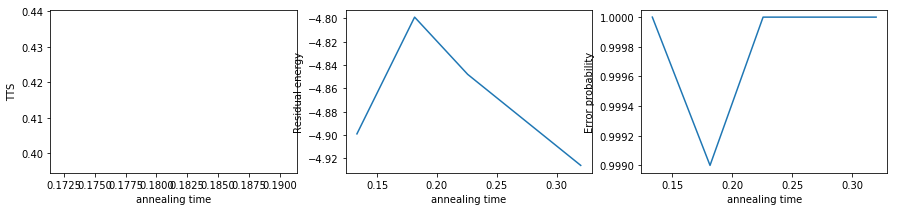

In [24]:
fig, (axL,axC,axR) = plt.subplots(ncols=3, figsize=(15,3))
fontsize = 10
axL.plot(result['time'], result['tts'])
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_ylabel('TTS', fontsize=fontsize)

axC.plot(result['time'], result['e_res'])
axC.set_xlabel('annealing time', fontsize=fontsize)
axC.set_ylabel('Residual energy', fontsize=fontsize)

axR.plot(result['time'], result['error'])
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Error probability', fontsize=fontsize)

fig.show()